Summary Statistics - ADF Test For Stationarity

P Value is high. Consider Differencing: 0.23609216446571168


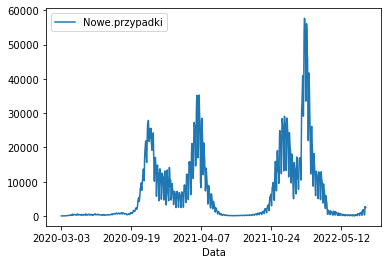

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import LSTM_Prepare

#%run LSTM_Prep.py
# Data
data_path = "E:/page ds/pages/ts_covid19/covid19_dane.csv" 




dat = pd.read_csv(data_path)

split = (len(dat) - 21)/len(dat)
sequence_length = 30

data_prep = LSTM_Prepare.Data_Prep(dataset = dat)
rnn_df, validation_df = data_prep.preprocess_rnn(date_colname = 'Data', numeric_colname = 'Nowe.przypadki', pred_set_timesteps = 30)


In [5]:
(len(dat) - 21)/len(dat)

0.9758897818599311

In [2]:
series_prep = LSTM_Prepare.Series_Prep(rnn_df =  rnn_df, numeric_colname = 'Nowe.przypadki')
window, X_min, X_max = series_prep.make_window(sequence_length = sequence_length, 
                                               train_test_split = split, 
                                               return_original_x = True)

X_train, X_test, y_train, y_test = series_prep.reshape_window(window, train_test_split = split)



In [3]:

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#                 Building the LSTM
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau #Learning rate scheduler for when we reach plateaus
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

# Reset model if we want to re-train with different splits
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)  


# Epochs and validation split
EPOCHS = 101
validation = 0.05

# Instantiate the model
model = Sequential()

# Add the first layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1), return_sequences = True,
        units = 60))

# Add the second layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1), 
        units = 60))

# Add the output layer, simply one unit 
model.add(Dense(
        units = 1,
        activation = 'sigmoid'))

model.compile(loss = 'mse', optimizer = 'adam')


Epoch 1/101
22/22 [==============================] - 2s 36ms/step - loss: 0.1017 - val_loss: 0.0843 - lr: 0.0010
Epoch 2/101
22/22 [==============================] - 0s 13ms/step - loss: 0.0321 - val_loss: 0.0360 - lr: 0.0010
Epoch 3/101
22/22 [==============================] - 0s 12ms/step - loss: 0.0271 - val_loss: 0.0140 - lr: 0.0010
Epoch 4/101
22/22 [==============================] - 0s 12ms/step - loss: 0.0161 - val_loss: 0.0561 - lr: 0.0010
Epoch 5/101
22/22 [==============================] - 0s 13ms/step - loss: 0.0140 - val_loss: 0.0290 - lr: 0.0010
Epoch 6/101
22/22 [==============================] - 0s 12ms/step - loss: 0.0105 - val_loss: 0.0258 - lr: 0.0010
Epoch 7/101
22/22 [==============================] - 0s 12ms/step - loss: 0.0090 - val_loss: 0.0083 - lr: 0.0010
Epoch 8/101
22/22 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0150 - lr: 0.0010
Epoch 9/101
22/22 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0

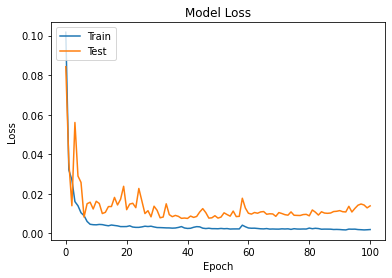

See Plot for predicted vs. actuals


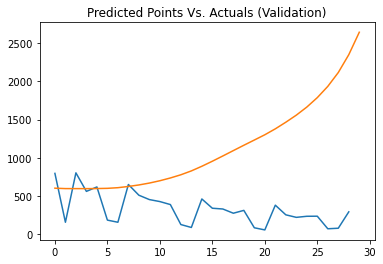

Validation Vs. Predicted
Validation     7263.000000
Predicted     33741.102372
dtype: float64
See Plot for Future Predictions


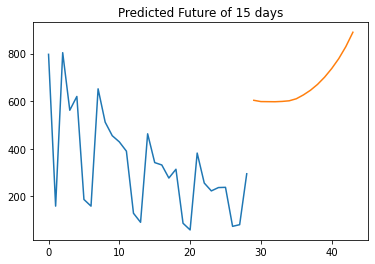

,Nowe.przypadki,historical_flag
29,603.799872,0
30,598.412776,0
31,598.072538,0
32,597.773541,0
33,599.089814,0
34,601.722361,0
35,610.202527,0
36,626.315702,0
37,645.929201,0
38,670.596433,0


In [4]:


# History object for plotting our model loss by epoch
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_split = validation,
          callbacks = [rlrop])
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#              Predicting the future
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# Creating our future object
future = LSTM_Prepare.Predict_Future(X_test  = X_test, validation_df = validation_df, lstm_model = model)
# Checking its accuracy on our training set
future.predicted_vs_actual(X_min = X_min, X_max = X_max, numeric_colname = 'Nowe.przypadki')
# Predicting 'x' timesteps out
future.predict_future(X_min = X_min, X_max = X_max, numeric_colname = 'Nowe.przypadki', timesteps_to_predict = 15, return_future = True)
